In [78]:
import networkx as nx
import sqlite3
from tqdm import tqdm
import warnings
import json
import pandas as pd
import tweepy
import pydot
import numpy as np
from matplotlib import pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)


In [52]:
# Load Twitter credentials
api_keys = json.load(open('twitter-api-keys.local.json'))
bearer_token = api_keys["bearer_token"]
client = tweepy.Client(
    bearer_token=api_keys['bearer_token'], wait_on_rate_limit=True)

auth = tweepy.OAuthHandler(
    consumer_key=api_keys['api_key'],
    consumer_secret=api_keys['api_key_secret'],
    access_token=api_keys['access_token'],
    access_token_secret=api_keys['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)


In [53]:
# Create databases and tables
conn = sqlite3.connect('twitter.db')
c = conn.cursor()
c.execute('''CREATE TABLE IF NOT EXISTS users
                (id INTEGER PRIMARY KEY NOT NULL,
                screen_name TEXT NOT NULL,
                followers_count INTEGER,
                following_count INTEGER,
                verified INTEGER,
                followers TEXT DEFALUT '',
                friends TEXT DEFALUT '',
                mutuals TEXT DEFALUT '')''')


In [54]:
# # delete database
# c.execute('''DROP TABLE IF EXISTS paths''')
# conn.commit()

In [55]:
me = 'fcx_xm'
me_info = api.get_user(screen_name=me)
c.execute('''INSERT OR IGNORE INTO users
                (id, screen_name, followers_count, following_count, verified)
                VALUES (?, ?, ?, ?, ?)''',
                (me_info.id, me_info.screen_name, me_info.followers_count,
                me_info.friends_count, me_info.verified))
conn.commit()

def fetch(screen_name, type):
    """
    Fetch the followers or friends of a user.
    """
    if type == 'followers':
        f = c.execute('''SELECT followers FROM users WHERE screen_name = ?''', (screen_name,)).fetchone()[0]
    elif type == 'friends':
        f = c.execute('''SELECT friends FROM users WHERE screen_name = ?''', (screen_name,)).fetchone()[0]
    elif type == 'mutuals':
        f = c.execute('''SELECT mutuals FROM users WHERE screen_name = ?''', (screen_name,)).fetchone()[0]
    return json.loads(f) if f else None


In [56]:
# Create errors table with id, method, username, error
def save_error(method, username, error):
    if 'KeyboardInterrupt' in error:
        return
    c.execute('''CREATE TABLE IF NOT EXISTS errors
                (id INTEGER PRIMARY KEY NOT NULL,
                method TEXT NOT NULL,
                username TEXT NOT NULL,
                error TEXT NOT NULL,
                timestamp TEXT NOT NULL,
                fixed INTEGER DEFAULT 0)''')
    c.execute('''INSERT INTO errors
                (method, username, error, timestamp)
                VALUES (?, ?, ?, ?)''',
                (method, username, error, str(pd.Timestamp.now())))
    conn.commit()


def get_followers(screen_name, override):
    """
    Get followers for a user. Builds database. If override is True, will overwrite existing followers. May be slow due to rate limits.    
    """
    print('Getting followers for ' + screen_name)
    
    if fetch(screen_name, 'followers') != None and not override:
        print('- Already have friends for ' + screen_name)
        return 

    ids = []
    for fid in tweepy.Cursor(api.get_follower_ids, screen_name=screen_name, count=5000).items():
        ids.append(fid)
    
    info = []
    for i in tqdm(range(0, len(ids), 100)):
        try:
            chunk = ids[i:i+100]
            info.extend(api.lookup_users(user_id=chunk))
        except:
            import traceback
            traceback.print_exc()
            print('Something went wrong, skipping...')
            save_error('get_friends', screen_name, traceback.format_exc())

    followers_list = {}
    for i in info:
        followers_list[i.id] = i.screen_name
        c.execute('''INSERT OR IGNORE INTO users
                        (id, screen_name, followers_count, following_count, verified)
                        VALUES (?, ?, ?, ?, ?)''',
                        (i.id, i.screen_name, i.followers_count, i.friends_count, i.verified))
    c.execute('''UPDATE users SET followers = ? WHERE screen_name = ?''',
                (json.dumps(followers_list), screen_name))
    conn.commit()

def get_friends(screen_name, override):
    """
    Get friends for a user. Builds database. If override is True, will overwrite existing friends. May be slow due to rate limits.
    """
    print('Getting friends for ' + screen_name)

    if fetch(screen_name, 'friends') != None and not override:
        print('- Already have friends for ' + screen_name)
        return 

    ids = []
    for fid in tweepy.Cursor(api.get_friend_ids, screen_name=screen_name, count=5000).items():
        ids.append(fid)
    
    info = []
    # Progress bar for getting friends info
    for i in tqdm(range(0, len(ids), 100)):
        try:
            chunk = ids[i:i+100]
            info.extend(api.lookup_users(user_id=chunk))
        except:
            import traceback
            traceback.print_exc()
            print('Something went wrong, skipping...')
            save_error('get_friends', screen_name, traceback.format_exc())

    friends_list = {}
    for i in info:
        friends_list[i.id] = i.screen_name
        c.execute('''INSERT OR IGNORE INTO users
                        (id, screen_name, followers_count, following_count, verified)
                        VALUES (?, ?, ?, ?, ?)''',
                        (i.id, i.screen_name, i.followers_count, i.friends_count, i.verified))
                        
    c.execute('''UPDATE users SET friends = ? WHERE screen_name = ?''',
                (json.dumps(friends_list), screen_name))
    conn.commit()

def get_mutuals(screen_name, override):
    """
    Get mutuals for a user. Builds database.
    """
    get_followers(screen_name, override)
    followers = fetch(screen_name, 'followers')
    get_friends(screen_name, override)
    friends = fetch(screen_name, 'friends')
    mutuals = followers.keys() & friends.keys()
    mutuals = {k: friends[k] for k in mutuals}

    c.execute('''UPDATE users SET mutuals = ? WHERE screen_name = ?''',
                (json.dumps(mutuals), screen_name))
    conn.commit()


In [57]:
def build_mutuals_df(screen_name):
    """
    Returns a dataframe of mutuals to the given username with their respective info.
    """
    mutuals_json = json.loads(c.execute('''SELECT mutuals FROM users WHERE screen_name = ?''', (screen_name,)).fetchone()[0])
    return pd.read_sql_query('''SELECT * FROM users WHERE id IN ({})'''.format(','.join(map(str, mutuals_json.keys()))), conn)


In [58]:
def get_filtered_users(mutuals_df, rules, exclude):
    """
    Checks if user meets the rules and excludes the ones that do not. Returns a dataframe of users.
    """
    mutuals_matching = []
    verified = []
    min_followers = []
    for index, row in mutuals_df.iterrows():
        if row['screen_name'] not in exclude and 'verified' in rules and row['verified'] == rules['verified']:
            verified.append(row['id'])
        if row['screen_name'] not in exclude and 'min_followers' in rules and row['followers_count'] >= rules['min_followers']:
            min_followers.append(row['id'])

    mutuals_matching = list(set(verified) & set(min_followers))
    mutuals_matching_df = mutuals_df.loc[mutuals_df['id'].isin(
        mutuals_matching)]
    return mutuals_matching_df

In [59]:
def save_path(path, rules):
    """
    Save path to database if it doesn't exist.
    """
    c.execute('''CREATE TABLE IF NOT EXISTS paths (
        id INTEGER PRIMARY KEY,
        path TEXT,
        rules TEXT,
        src TEXT,
        dst TEXT,
        length INTEGER
        )''')

    src = path[0]
    dst = path[-1]
    length = len(path)
    path_json = json.dumps(path)
    rules_json = json.dumps(rules)
    # Check if already exists
    if c.execute('''SELECT * FROM paths WHERE path = ? AND rules = ? AND src = ? AND dst = ? AND length = ?''',
                 (path_json, rules_json, src, dst, length)).fetchone() == None:
        c.execute('''INSERT INTO paths (path, rules, src, dst, length) VALUES (?, ?, ?, ?, ?)''',
                  (path_json, rules_json, src, dst, length))
        conn.commit()

In [98]:
def get_stored_paths(screen_name):
    """
    Selects all paths from the database that have the given screen_name as src.
    """
    paths = []
    c.execute('''SELECT * FROM paths WHERE src = ?''', (screen_name,))
    for row in c.fetchall():
        paths.append(json.loads(row[1]))
    return paths

In [113]:
def shortest_path_to_celeb(exclude, override):
    """
    Finds the shortest path from the user to the celebrity with most users, building a path and saving it to the database along the info of the path's users.
    """
    path = []
    max_depth = 3
    rules = {'verified': True, 'min_followers': 1e5}
    found = False
    i = 0
    current_user = me
    path.append(current_user)
    while ((len(path) <= max_depth) and (not found)):
        i += 1
        print('Current user: {}'.format(current_user))
        get_mutuals(current_user, override)
        mutuals_df = build_mutuals_df(current_user)

        mutuals_matching = get_filtered_users(mutuals_df, rules, exclude)

        # TODO: add backtracking when max_depth is reached and no match is found or max depth is reached
        if len(mutuals_matching) == 0:
            print('No matching users found')
            mutuals_df = mutuals_df.loc[~mutuals_df['screen_name'].isin(
                exclude)]
            current_user = mutuals_df.sort_values(
                'followers_count', ascending=False).iloc[0]['screen_name']
            path.append(current_user)
        else:
            most_followers = mutuals_matching.sort_values(
                'followers_count', ascending=False).iloc[0]
            path.append(most_followers['screen_name'])

            print('Matching user with most followers: {}, with {} followers. Rules being {}'.format(
                most_followers['screen_name'], most_followers['followers_count'], rules))

            found = True

        print('Built path: {}'.format(path))

    save_path(path, rules)
    return path

def get_more_celebs():
    """
    Get more celebrities from the database. Main function takes only the most popular.
    """
    paths = get_stored_paths(me)
    for path in paths:
        path_df = build_mutuals_df(path[-2])
        path_df = get_filtered_users(path_df, {'verified': True, 'min_followers': 1e5}, [])
        path_df = path_df.loc[~path_df['screen_name'].isin(path)]
        for index, row in path_df.iterrows():
            p = path[:-1]
            p.append(row['screen_name'])
            save_path(p, {'verified': True, 'min_followers': 1e5})


In [73]:
max_paths = 5
exclude_users = ['vodafone_es']
user_paths = c.execute('''SELECT * FROM paths WHERE src = ?''',
                            (me,)).fetchall()
n_paths = len(user_paths)

while n_paths < max_paths:
    user_paths = c.execute('''SELECT * FROM paths WHERE src = ?''',
                            (me,)).fetchall()
    n_paths = len(user_paths)
    print('{} paths found'.format(n_paths))
    for p in user_paths:
        path = json.loads(p[1])
        exclude_users += path[1:]

    new_path = shortest_path_to_celeb(exclude_users, False)

n_paths = len(user_paths)
print('{} paths found for {}:'.format(n_paths, me))
for p in user_paths:
    path = json.loads(p[1])
    print('- ' + ', '.join(path))

5 paths found for fcx_xm:
- fcx_xm, Meescapo, Loulogio_Pi
- fcx_xm, bunnana99, littleragergirl
- fcx_xm, mellamoae, levmauc, auronplay
- fcx_xm, tooclosefor, SoyAmargada, AlejandroSanz
- fcx_xm, NinoskaDarko, WipeHomophobia


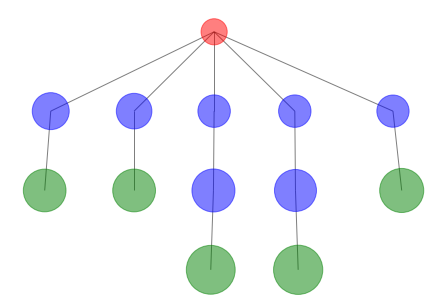

In [97]:
from networkx.drawing.nx_agraph import graphviz_layout

def path_as_edges(path):
    edges = []
    for i in range(len(path) - 1):
        edges.append((path[i], path[i+1]))
    return edges

G = nx.Graph()
paths = get_stored_paths(me)
for path in paths:
    G.add_nodes_from(path)
    G.add_edges_from(path_as_edges(path))

color_map = []
node_sizes = []

for node in G:
    c.execute('''SELECT followers_count FROM users WHERE screen_name = ?''', (node,))
    node_sizes.append(np.log2(c.fetchone()[0])*100)
    # if node is me then red
    if node == me:
        color_map.append('r')
    # if node has only one connection then green
    elif len(list(G.neighbors(n=node))) == 1:
        color_map.append('g')
    else:
        color_map.append('b')
    


pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, node_size=node_sizes, node_color=color_map, alpha=0.5, with_labels=False)
plt.show()